# Example of the usage PyXLA with 1D Lobster-eye optics

The simulated design has following parameters:
 
 ## Parameters
 ### 1D Optics

| Properties        | Value      |
|-------------------|:----------:|
| Thickness         |  0.35 mm   |
| Length            |  150 mm    | 
| Width             |  75 mm     |
| Coating           |  Gold      |
| Focal Length      |  965 mm    | 
| Number of mirrors |  47        |
| Spacing           |  0.75 mm   |
 
### Detector

| Properties        | Value             |
|-------------------|:-----------------:|
| Type              |  Timepix          |
| Matrix            |  256 x 256 px     | 
| Pitch             |  55 um            |
| Area              |  14.08 x 14.08 mm |

### Source

| Properties           | Value             |
|----------------------|:-----------------:|
| Position             |  Infinity         |
| Energy               |  8 keV            |
| Intesity             |  uniform - 1      | 
| Spacing between rays |  27.5 um          |
| Rays array           |  1000 x 1000 rays |

## Import Libraries

In [1]:
import src.setup3D as setup3D
import src.ray as ray
import src.objects as objects
import src.functions as functions

import math
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot as rcParams
from matplotlib import cm

## Define initial settings
  - Create output folder if not exists
  - No 3D output
  - Set detector Timepix
 

In [2]:
# Check if output directory exists, if not, create it
functions.createDir("outputs")

# Decision if the 3D will be printed out and includes rays
draw3D   = False
drawRays = False

# Set detector
detectorType = 'timepix'

## Define Source
 - Spacing between rays 27.5 um
 - Number of rays 1000 x 1000
 - Angle of the source from input aperture 0° x 0°
 - Focus point se set 10 nm aside because of simulation reliablity
 - Detector, optics offset set to 0

In [3]:
divH = 1
divV = 1

divXmm = 0.0275           # set pitch between rayx
divYmm = 0.0275

noPoints = (1000, 1000)      #set number of point in x,y

angleX = 0.000000000    # in degrees
angleY = 0.000000000    # in degrees

# Define input points
focusPoint = np.array([0.00001, 0.00001, 0.00001])     # detector position 
detectorOffset = np.array([0,0,0])
vStackOffset = np.array([0,0,0])
hStackOffset = np.array([0,0,0])

## Create mirrors stack (optics), detector and 3D setup
 - Create free array `mirrors` for storing mirrors stack
 - Create mirrors stack by function `objects.createMirrorModule`
 - Append to existing array by function `mirrors.append(vStack)`
 - Create detector
 - Create complete 3D setup and eventually plot the setup if `draw3D == True`

In [4]:
mirrors = []

# create mirror module
vStack  = objects.createMirrorModule(47, 150, 75, 0.35, 0.75, True, 'V', focusPoint + vStackOffset, 965*2)
aperturePoint = np.array([-vStack.focusLength - vStack.mDepth/2, 0, 0])
mirrors.append(vStack)

# create detector
det = objects.createDetector(focusPoint + detectorOffset, detectorType)

# create 3D setup
stp = setup3D.Setup3D(np.array(mirrors), det, drawRays)

if draw3D:
    stp.plot_setup([-2000, 5], [-60, 60], [-60, 60])

## Create radiation source
  - Energy is selected 8 keV, but can by used another or customised by including new reflectivity file which contains three columns separated by comma
    - `Angle` in degrees
    - `Reflectivity` in range 0-1
    - `Transmission into substrate` in range 0-1
  - Define position in Z-axis 
  - Compute source position and direction vector which faces toward input aperture
  - Create rays array by function `ray.RaySourceParallel`

In [5]:
# Add energy reflectivity model
stp.appendEnergy(8048, "./inputs/reflectivity/8048eV.dat") #  0...2 degs

# set the number of channels for the detector to the number of energies used
numEnergies = len(stp.energies)
det.setChannels(numEnergies)  

# define center and direction of the radiation source 
inputAperture = (noPoints[0]*divXmm, noPoints[1]*divYmm)
srcZposition = -1e12
srcPosition = np.array([srcZposition, ((srcZposition + aperturePoint[0]) * math.tan(math.radians(angleY))), ((srcZposition + aperturePoint[0]) * math.tan(math.radians(angleX)))]) 

# calculate direction vector
direct = aperturePoint - srcPosition
direct = np.array(direct / np.linalg.norm(direct))

# create the source given the center, direction and number of mirror stacks
src1 = ray.RaySourceParallel(srcPosition, direct, stp.mirrorStacks.size)


## Run simulation
 - Intensity is defined by variable array `inten`
 - Simulation is executed by function `src1.processRectGrid` where
   - `[0, 1, 0]` is orientation
   - `inputAperture` is size of input aperture
   - `ray.SourceType.SOURCE_UNIFORM` determine type of source
   - `int(noPoints[0]/divH)` is reduced number of rays if divH is higher than 1
   - `int(noPoints[1]/divV))` is reduced number of rays if divV is higher than 1
   - `inten` is input intensity array
   - `stp` is physical layout
`

In [6]:
# initialise all intensities to 1 (all rays emit all energies with unit intensity)
inten = np.ones(numEnergies)

# run simulation
src1.processRectGrid([0, 1, 0], inputAperture, ray.SourceType.SOURCE_UNIFORM, (int(noPoints[0]/divH), int(noPoints[1]/divV)), inten, stp) 


Using 16 CPUs/Threads


## Plot results
 - Save arrangement with rays by function `stp.pltr.fig.savefig` into image `outputs/arrangement.png` if `draw3D == True`
 - Save resulting image as txt file by function `np.savetxt` into file `8keV_1D_3points.txt`
 - Print FWHM value and maximum peak value
 - Visualize image in 2D and in 3D including histograms

![documents/1D_lobster_eye_output.png](documents/1D_lobster_eye_output.png)

FWHM: 6.64 px
FWTM: 18.25 px
Peak: 128.02


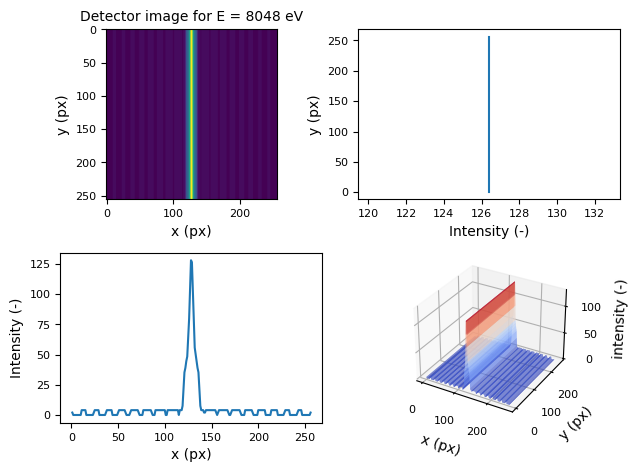

In [27]:
size = 10
# save arrangement if is intened to save it
if(draw3D) :
    stp.pltr.fig.savefig('outputs/arrangement.png', format='png', bbox_inches="tight",  dpi=600)
    plt.show()

x=np.linspace(1,stp.detector.pix_x_no, num=stp.detector.pix_x_no)
np.savetxt('8keV_1D_3points.txt',stp.detector.pix_ar,fmt='%.5f')

row = stp.detector.pix_ar[int(stp.detector.pix_x_no/2)]
fwhmVal = functions.fwhm(row, x)
fwtmVal = functions.fwhm(row, x, 0.1)
maxVal = stp.detector.pix_ar.max()

print("FWHM: %.2f px" % (fwhmVal))
print("FWTM: %.2f px" % (fwtmVal))
print("Peak: %.2f" % (maxVal))

fig = plt.figure()
# plot image
plt.subplot(221)
plt.imshow(stp.detector.pix_ar)	
plt.title("Detector image for E = %d eV" % (stp.energies[0]), fontsize=size)
plt.xlabel("x (px)", fontsize=size)
plt.ylabel("y (px)", fontsize=size)
plt.tick_params(labelsize=0.8*size)

# plot histogram along y axis
plt.subplot(222)
arr = np.array(stp.detector.pix_ar).T
plt.plot(arr[int(stp.detector.pix_y_no/2)], x)
plt.xlabel("Intensity (-)", fontsize=size)
plt.ylabel("y (px)", fontsize=size)
plt.tick_params(labelsize=0.8*size)

# plot histogram along x axis
plt.subplot(223)
plt.plot(x, stp.detector.pix_ar[int(stp.detector.pix_x_no/2)])
plt.xlabel("x (px)", fontsize=size)
plt.ylabel("Intensity (-)", fontsize=size)
plt.tick_params(labelsize=0.8*size)

x=range(stp.detector.pix_x_no)
y=range(stp.detector.pix_y_no)
X, Y = np.meshgrid(x, y)

# plot image in 3D
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, stp.detector.pix_ar, cmap=cm.coolwarm, rstride=1, cstride=1)
ax.set_xlabel("x (px)", fontsize=size)
ax.set_ylabel("y (px)", fontsize=size)
ax.set_zlabel("intensity (-)", fontsize=size)
ax.tick_params(labelsize=0.8*size)

fig.tight_layout(pad=1)
plt.show()
